In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load common functions
# %run common.ipynb
import ipynb.fs.full.common as common

In [3]:
MML_VARIABLE_ANALYZED = 'EXLIFE'
REGION = 'LAM'

In [4]:
df = pd.read_excel('data/Life Expectancy.xlsx', sheet_name='countries_and_territories')
df[0:5]

,geo.name,indicator.name,geo,indicator,1800,1801,1802,1803,1804,1805,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Abkhazia,Life expectancy,abkh,lex,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Life expectancy,afg,lex,28.21,28.20,28.19,28.18,28.17,28.16,...,69.95,70.07,70.19,70.31,70.44,70.57,70.70,70.83,70.96,71.09
2,Akrotiri and Dhekelia,Life expectancy,akr_a_dhe,lex,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,Life expectancy,alb,lex,35.40,35.40,35.40,35.40,35.40,35.40,...,88.29,88.40,88.51,88.62,88.73,88.84,88.95,89.06,89.17,89.28
4,Algeria,Life expectancy,dza,lex,28.82,28.82,28.82,28.82,28.82,28.82,...,89.37,89.49,89.61,89.73,89.85,89.97,90.09,90.21,90.33,90.45


In [5]:
del df['indicator.name']
del df['geo']
del df['indicator']
df.columns = df.columns.astype(str)
df[0:5]

,geo.name,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,28.21,28.20,28.19,28.18,28.17,28.16,28.15,28.14,28.13,...,69.95,70.07,70.19,70.31,70.44,70.57,70.70,70.83,70.96,71.09
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,35.40,35.40,35.40,35.40,35.40,35.40,35.40,35.40,35.40,...,88.29,88.40,88.51,88.62,88.73,88.84,88.95,89.06,89.17,89.28
4,Algeria,28.82,28.82,28.82,28.82,28.82,28.82,28.82,28.82,28.82,...,89.37,89.49,89.61,89.73,89.85,89.97,90.09,90.21,90.33,90.45


In [6]:
print("Missing countries for region")
print(common.get_missing_countries_for_region(df, 'geo.name', REGION))

Missing countries for region
set()


In [7]:
df_truth = common.get_countries_for_region(df, 'geo.name', REGION)
assert len(df_truth) == len(common.regions[REGION]['countries']), 'MISSING COUNTRIES FOR REGION'

According to dataset documentation, it start predicting after 2019.
So, we only consider data until that year
See https://www.gapminder.org/data/documentation/gd003/

In [8]:
years_filtered = np.arange(1970,2020,2)
columns_filter = np.append(['geo.name'],years_filtered)

df_truth = df_truth[columns_filter]
assert 0 == df_truth.isna().sum().sum(), "MISSING VALUES. CONSIDER FILL STRATEGY" #If 0, then we don't have missing values.

Finally, we got our truth dataframe. Now, MML

In [9]:
df_mml = common.get_mml_data()
df_mml = df_mml[['Year',MML_VARIABLE_ANALYZED]]
df_mml = df_mml[df_mml.Year <= 2018]
df_mml[0:3]

,Year,EXLIFE
0,1960,55.60
1,1962,56.95
2,1964,58.03


Ok, that was easy. Back to truth df. 
We need to transpose df, and group by some condition

In [10]:
df_T = df_truth.set_index('geo.name').T
df_T = df_T.reset_index().rename(columns={"index": "Year"})
df_truth = df_T.astype({'Year': 'int64'})
df_truth['mean'] = df_truth.iloc[:, 1:len(common.regions[REGION]['countries'])+1].mean(axis=1)
df_truth_aggs = df_truth[['Year','mean']]

In [11]:
df = pd.merge(df_mml,df_truth_aggs,on='Year').rename(columns={"EXLIFE": "mml_value", "mean":"truth_mean"})
df[0:3]

,Year,mml_value,truth_mean
0,1970,61.05,61.986364
1,1972,61.66,62.956364
2,1974,62.26,64.215455


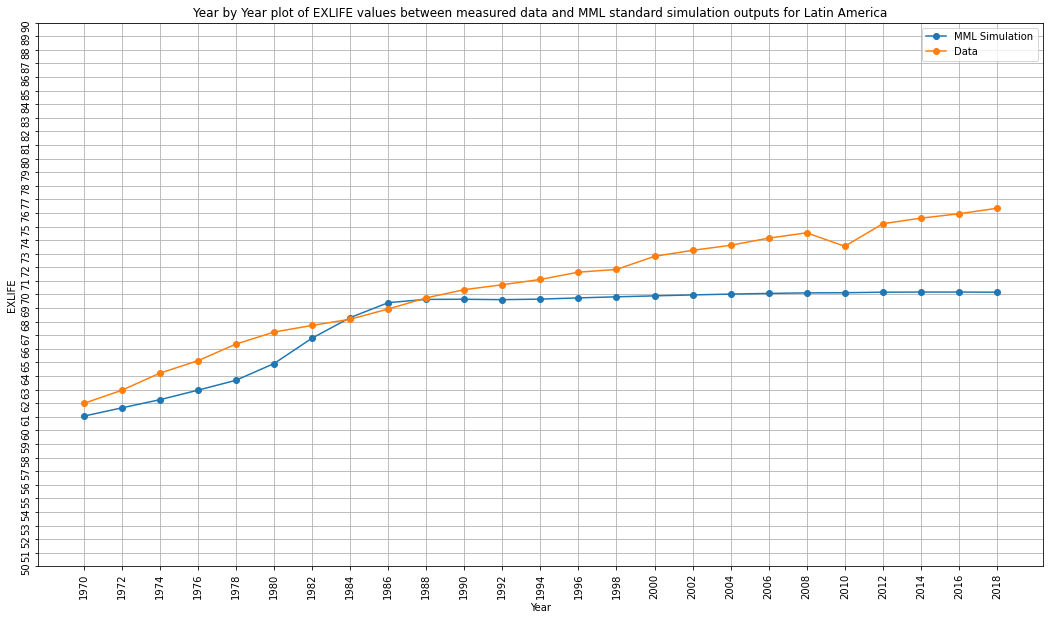

In [12]:
common.compare_mml_vs_truth_line_plot(df=df, x_col_name='Year', y_col_mml='mml_value', y_col_truth='truth_mean',variable_analyzed=MML_VARIABLE_ANALYZED, region=REGION, y_ticks=np.arange(50,91))

As we see in the graph, from 1988, mml stops growing as the others continue the tendence.

### 1970 - 1988

So, let's take only from 1970-1988

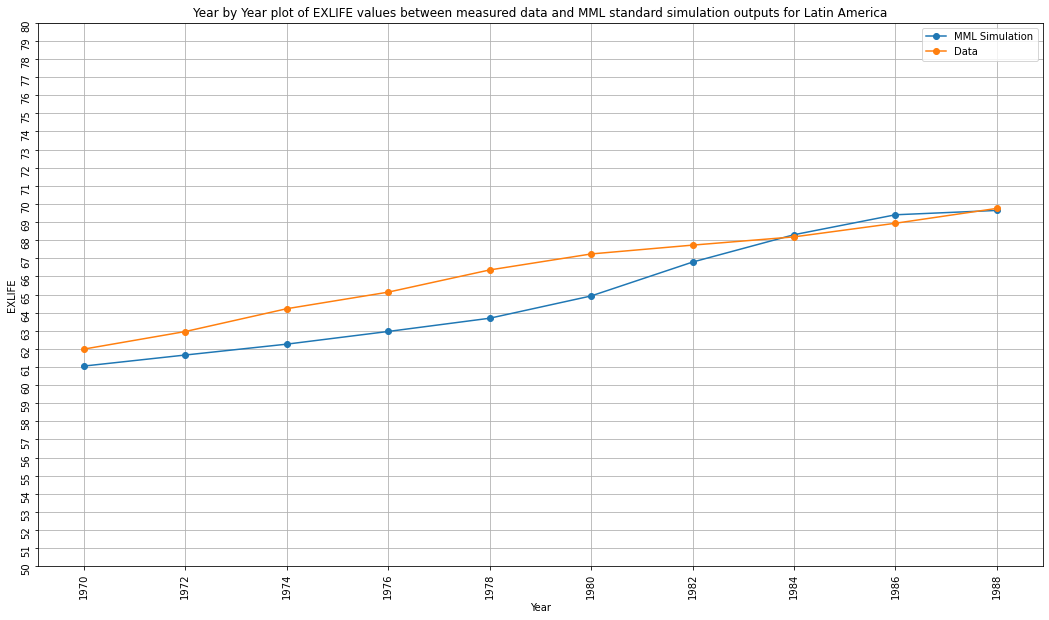

In [13]:
df_1988 = df[df['Year']<=1988]
common.compare_mml_vs_truth_line_plot(df=df_1988, x_col_name='Year', y_col_mml='mml_value', y_col_truth='truth_mean',variable_analyzed=MML_VARIABLE_ANALYZED, region=REGION, y_ticks=np.arange(50,81))

Mean seems to be quite accurate in that interval

### Error visualization

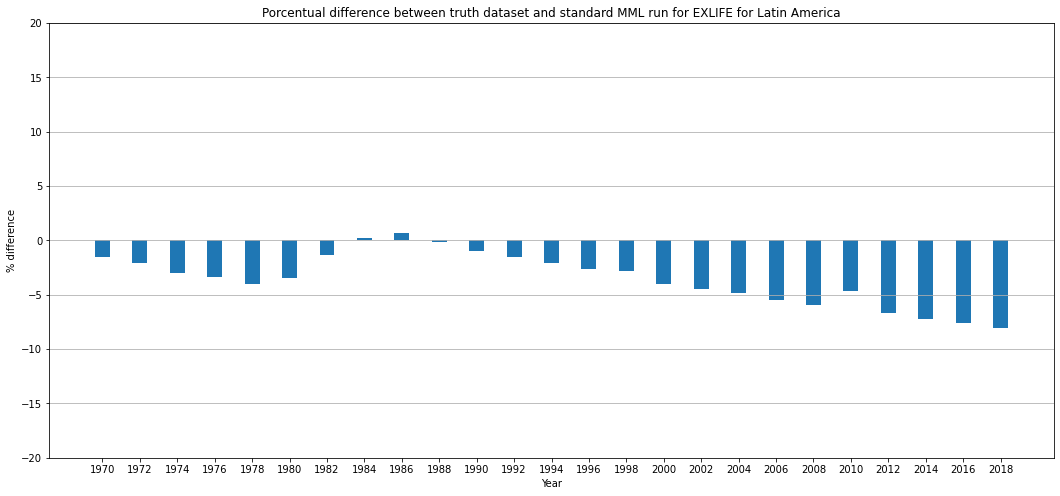

In [14]:
common.compute_porcentual_diff_between_truth_and_mml(df,'mml_value', 'truth_mean')
common.porcentual_diff_plot(df,MML_VARIABLE_ANALYZED, REGION, years_filtered, np.arange(-20,21,5))

In [15]:
common.save_porcentual_diff_to_excel_for_variable(df, MML_VARIABLE_ANALYZED)